In [3]:
import collections
import pickle

import matplotlib
import numpy as np
import seaborn as sns
import sklearn

from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn import manifold
from transformers import BertConfig, BertTokenizer, BertModel

In [4]:
import easydict
args = easydict.EasyDict({
    'bert_config_file' : 'result/my-unsup-simcse-bert-base-uncased/config.json',
    'model_checkpoint' : 'result/my-unsup-simcse-bert-base-uncased/pytorch_model.bin',
})

In [5]:
bert_config = BertConfig.from_json_file(args.bert_config_file)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained(args.model_checkpoint, config=bert_config)

Some weights of BertModel were not initialized from the model checkpoint at result/my-unsup-simcse-bert-base-uncased/pytorch_model.bin and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
sentences = ["Find definitions and references for functions and other symbols in this file.", "Discover explanations and sources for functions and other symbols contained within this document.", ""]

In [23]:
sentences = ["After a long day at work, I decided to relax by taking a hot bath and reading a good book.",
             "Following a tiring day at the office, I chose to unwind by indulging in a soothing shower and immersing myself in a captivating novel.",
             "Instead of relaxing after a long day at work, I found myself caught up in a hectic evening filled with unexpected tasks"]

In [24]:
#sentences = ["Find definitions and references for functions and other symbols in this file.", "Discover explanations and sources for functions and other symbols in this file."]
inputs = tokenizer(sentences, return_tensors="pt", padding=True)

In [25]:
output = model(**inputs, output_attentions=True)
attention_map = output.attentions

In [26]:
from torch import nn
cos = nn.CosineSimilarity(dim=-1)
cos(output.last_hidden_state[0, 0], output.last_hidden_state[1, 0])

tensor(0.8381, grad_fn=<DivBackward0>)

In [27]:
cos(output.last_hidden_state[0, 0], output.last_hidden_state[2, 0])

tensor(0.8184, grad_fn=<DivBackward0>)

In [29]:
cos(output.last_hidden_state[0,1], output.last_hidden_state[1,1])

tensor(0.7875, grad_fn=<DivBackward0>)

In [36]:
# http://stackoverflow.com/questions/14391959/heatmap-in-matplotlib-with-pcolor
def plot_head_map(mma, target_labels, source_labels):
    plt.figure(figsize=(20, 20))
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(mma, cmap=plt.cm.Blues)
    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(mma.shape[1]) + 0.5, minor=False) # mma.shape[1] = target seq 길이
    ax.set_yticks(np.arange(mma.shape[0]) + 0.5, minor=False) # mma.shape[0] = input seq 길이
 
    # without this I get some extra columns rows
    # http://stackoverflow.com/questions/31601351/why-does-this-matplotlib-heatmap-have-an-extra-blank-column
    ax.set_xlim(0, int(mma.shape[1]))
    ax.set_ylim(0, int(mma.shape[0]))
 
    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()
 
    # source words -> column labels
    ax.set_xticklabels(source_labels, minor=False)
    # target words -> row labels
    ax.set_yticklabels(target_labels, minor=False)
 
    plt.xticks(rotation=45)
 
    # plt.tight_layout()
    plt.show()
 
 
def read_plot_alignment_matrices(source_labels, target_labels, alpha):
 
    mma = alpha.detach().numpy()
 
    plot_head_map(mma, target_labels, source_labels)

<Figure size 1440x1440 with 0 Axes>

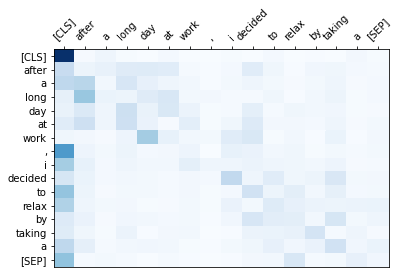

In [44]:
tokens = tokenizer(sentences[0], padding='max_length', truncation=True)['input_ids']
tokens = tokenizer.convert_ids_to_tokens(tokens)
read_plot_alignment_matrices(tokens, tokens, output.attentions[0][0][-1][:16, :16])

<Figure size 720x720 with 0 Axes>

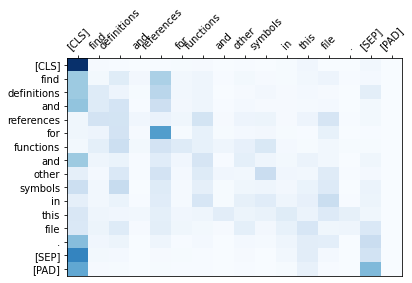

In [14]:
pre_trained_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pre_trained_model_name)
pretrained_model = BertModel.from_pretrained(pre_trained_model_name)
output = pretrained_model(**inputs, output_attentions=True)
read_plot_alignment_matrices(tokens, tokens, output.attentions[0][0][-1])